# Estimation of the apparent baseline
Author: Alessio Galluccio

Tool: Google Colab

In this notebook we will try to estimate the apparent baseline of the robot and the gear ratio of the motors. We use bag1 as data. This notebook doesn't need to add data manually, since it automatically downloads it from a repository I created. To obtain the csv files from the bag, I used the library bagpy and a simple script.

In the first part of the notebook, we set up the data and the methods needed for the search of the optimal values. In the second part, we use the data of the odometry to estimate the value Y0 (which is half the apparent baseline) and the gear ratio. In the third part, we use the ground truth to estimate them

## 1) Setting up of data and functions

In [1]:
#import data of bag from my repository
!git clone https://github.com/AlessioGalluccio/Bag1_robotics_data

Cloning into 'Bag1_robotics_data'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 3), reused 8 (delta 3), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [2]:
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
import numpy as np

In [3]:
scout_odom = pd.read_csv("Bag1_robotics_data/scout_odom.csv")
gt_pose = pd.read_csv("Bag1_robotics_data/gt_pose.csv")
fl = pd.read_csv("Bag1_robotics_data/motor_speed_fl.csv")
fr = pd.read_csv("Bag1_robotics_data/motor_speed_fr.csv")
rl = pd.read_csv("Bag1_robotics_data/motor_speed_rl.csv")
rr = pd.read_csv("Bag1_robotics_data/motor_speed_rr.csv")

In [4]:
import math

#euler_skid
def euler_skid(x,y,o,v_forward,vo,T):
  vx= v_forward*math.cos(o)
  vy= v_forward*math.sin(o)
  next_x= x+vx*T
  next_y= y+vy*T
  next_o= o+vo*T
  number_of_rounds = math.floor(next_o /(2*math.pi))
  next_o = next_o - number_of_rounds*(2*math.pi)
  if(next_o > math.pi):
    next_o= next_o - (2*math.pi) #obtain negative radiants
  if(next_o <= -math.pi):
    next_o= next_o + (2*math.pi) #obtain positive radiants
  return next_x, next_y, next_o

#loss used: sum of squared errors of x, y and orientation
def loss(x_eul, y_eul, o_eul, x_true, y_true, z_true):
  return math.sqrt(math.pow(x_eul - x_true, 2) + math.pow(y_eul - y_true, 2) + math.pow(o_eul - z_true, 2))

#Skid steering
def skidSpeed(fl_rpm,fr_rpm,rl_rpm,rr_rpm,Y0, ROTATION_FOR_M, GEAR_RATIO):
  #GEAR_RATIO= 40
  SECONDS_IN_MINUTE = 60
  vel_right= (fr_rpm + rr_rpm)/(2 * ROTATION_FOR_M * GEAR_RATIO * SECONDS_IN_MINUTE)
  #I PUT MINUS BECAUSE LEFT VELOCITY ARE REVERSED
  vel_left= -(fl_rpm + rl_rpm)/(2 * ROTATION_FOR_M*GEAR_RATIO * SECONDS_IN_MINUTE)
  v_forward = (vel_right + vel_left)/2
  vo = (-vel_left + vel_right)/(2*Y0)
  return v_forward, vo

#obstain roll, pitch and yaw from a quaternion
def values_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians



In [5]:
#calculate all poses of the robot using euler method
def give_prediction(Y0, GEAR_RATIO):
  prediction=[]
  curr_x = scout_odom['pose.pose.position.x'][0]
  curr_y = scout_odom['pose.pose.position.y'][0]
  roll_x, pitch_y, yaw_z = values_from_quaternion(scout_odom['pose.pose.orientation.x'][0], scout_odom['pose.pose.orientation.y'][0], scout_odom['pose.pose.orientation.z'][0], scout_odom['pose.pose.orientation.w'][0])
  curr_z = yaw_z
  for t in scout_odom['Unnamed: 0'].to_numpy():
    if t!=0:
      vx, vo = skidSpeed(fl['rpm'][t], fr['rpm'][t], rl['rpm'][t], rr['rpm'][t], Y0, 1/(0.1575*2*3.14), GEAR_RATIO)
      curr_x, curr_y, curr_z = euler_skid(curr_x,
                                      curr_y, 
                                      curr_z, 
                                      vx, 
                                      vo,
                                      (((scout_odom['header.stamp.nsecs'][t] - scout_odom['header.stamp.nsecs'][t-1])/1000000000) + scout_odom['header.stamp.secs'][t] - scout_odom['header.stamp.secs'][t-1])
                                      )
      prediction.append([curr_x, curr_y, curr_z])
      #print(prediction[t-1])
  return prediction

## 2) Estimation from odom

### Y0 estimation
In the formula used we don't use directly the apparent baseline, but Y0, which is its half (apparent baseline = 2 * Y0). For simplicity, we optimise directly Y0, since it's the value we will use directly in the calulations in the ROS code

Here we can see how the frames of scout_odom and the speeds are organized (for simplicity, only the front left speed is showed)

In [6]:
scout_odom

,Unnamed: 0,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,child_frame_id,pose.pose.position.x,pose.pose.position.y,pose.pose.position.z,pose.pose.orientation.x,pose.pose.orientation.y,pose.pose.orientation.z,pose.pose.orientation.w,pose.covariance,twist.twist.linear.x,twist.twist.linear.y,twist.twist.linear.z,twist.twist.angular.x,twist.twist.angular.y,twist.twist.angular.z,twist.covariance
0,0,1.617792e+09,1116,1617791999,95527767,odom,base_link,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,1.617792e+09,1117,1617791999,115525756,odom,base_link,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,1.617792e+09,1118,1617791999,135545530,odom,base_link,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,1.617792e+09,1119,1617791999,155560259,odom,base_link,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,1.617792e+09,1120,1617791999,175564911,odom,base_link,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14130,14130,1.617792e+09,15246,1617792281,695527109,odom,base_link,-2.286034,-1.444192,0.0,-0.0,0.0,0.790465,-0.612507,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14131,14131,1.617792e+09,15247,1617792281,715546873,odom,base_link,-2.286034,-1.444192,0.0,-0.0,0.0,0.790465,-0.612507,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14132,14132,1.617792e+09,15248,1617792281,735523633,odom,base_link,-2.286034,-1.444192,0.0,-0.0,0.0,0.790465,-0.612507,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14133,14133,1.617792e+09,15249,1617792281,755542347,odom,base_link,-2.286034,-1.444192,0.0,-0.0,0.0,0.790465,-0.612507,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [7]:
fl

,Unnamed: 0,Unnamed: 0.1,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,rpm
0,0,0,1.617792e+09,1116,1617791999,95527767,NaN,0.0
1,1,1,1.617792e+09,1117,1617791999,115525756,NaN,0.0
2,2,2,1.617792e+09,1118,1617791999,135545530,NaN,0.0
3,3,3,1.617792e+09,1119,1617791999,155560259,NaN,0.0
4,4,4,1.617792e+09,1120,1617791999,175564911,NaN,0.0
...,...,...,...,...,...,...,...,...
14131,14131,14131,1.617792e+09,15247,1617792281,715546873,NaN,0.0
14132,14132,14132,1.617792e+09,15248,1617792281,735523633,NaN,0.0
14133,14133,14133,1.617792e+09,15249,1617792281,755542347,NaN,0.0
14134,14134,14134,1.617792e+09,15250,1617792281,775523705,NaN,0.0


We test the values of Y0 from 0.1 to 1.1 meters. We use the sum of the squared errors of x, y and orientation of the robot as loss function. We put as gear ratio 40 for two reasons. The first is that it's the one specified by the manual of the robot. The second one is that, as we will see later, it's clear that 40 is the best value for the gear ratio

In [8]:
#CURRENT MINIMUM: 0.489 (gear ratio 40)

loss_obtained = []
y0_tested = []
for y0 in np.arange(0.1,1.1,0.01):
  prediction = give_prediction(y0, 40)
  total_loss = 0
  #in 14000 we are sure not to find any error between scout_odom and speeds
  for t in range(14000):
    roll_x, pitch_y, yaw_z = values_from_quaternion(scout_odom['pose.pose.orientation.x'][t], scout_odom['pose.pose.orientation.y'][t], scout_odom['pose.pose.orientation.z'][t], scout_odom['pose.pose.orientation.w'][t])
    #print('x: ',scout_odom['pose.pose.position.x'][t], ' versus ', prediction[t][0])
    #print('y: ',scout_odom['pose.pose.position.y'][t], ' versus ', prediction[t][1])
    #print('o: ',yaw_z, ' versus ', prediction[t][2])
    total_loss += loss(prediction[t][0],prediction[t][1],prediction[t][2], scout_odom['pose.pose.position.x'][t], scout_odom['pose.pose.position.y'][t], yaw_z)
    #print(prediction[t])
  print('Y0: ', y0, ' loss: ', total_loss)
  loss_obtained.append(total_loss)
  y0_tested.append(y0)

Y0:  0.1  loss:  99620.10056588086
Y0:  0.11  loss:  92850.18983596512
Y0:  0.12  loss:  288146.4506655772
Y0:  0.13  loss:  90920.95015986622
Y0:  0.13999999999999999  loss:  156290.3279572262
Y0:  0.14999999999999997  loss:  96258.60451554396
Y0:  0.15999999999999998  loss:  90221.25181150311
Y0:  0.16999999999999998  loss:  83581.71962324723
Y0:  0.17999999999999997  loss:  103524.96298855319
Y0:  0.18999999999999995  loss:  91034.9845199436
Y0:  0.19999999999999996  loss:  122131.09228327786
Y0:  0.20999999999999996  loss:  205467.77456935763
Y0:  0.21999999999999995  loss:  283880.8083561975
Y0:  0.22999999999999995  loss:  314868.53483981243
Y0:  0.23999999999999994  loss:  296382.8889654829
Y0:  0.24999999999999992  loss:  244256.10482234546
Y0:  0.2599999999999999  loss:  182751.79947038533
Y0:  0.2699999999999999  loss:  130660.33237182864
Y0:  0.2799999999999999  loss:  104313.85894896674
Y0:  0.2899999999999999  loss:  89979.72425397132
Y0:  0.29999999999999993  loss:  75593

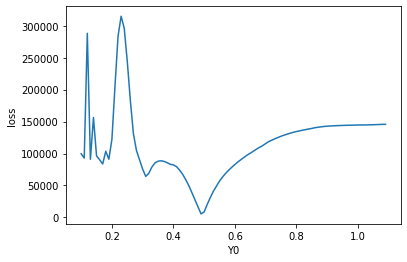

In [9]:
plt.plot(y0_tested ,loss_obtained)
plt.ylabel('loss')
plt.xlabel('Y0')
plt.show()

The best value for Y0 is around 0.49. We do another search in order to find the best value to the precision of 1 millimeter

In [10]:
#MINIMUM 0.494
loss_obtained = []
y0_tested = []
for y0 in np.arange(0.48,0.5,0.001):
  prediction = give_prediction(y0,40)
  total_loss = 0
  for t in range(14000):
    roll_x, pitch_y, yaw_z = values_from_quaternion(scout_odom['pose.pose.orientation.x'][t], scout_odom['pose.pose.orientation.y'][t], scout_odom['pose.pose.orientation.z'][t], scout_odom['pose.pose.orientation.w'][t])
    #print('x: ',scout_odom['pose.pose.position.x'][t], ' versus ', prediction[t][0])
    #print('y: ',scout_odom['pose.pose.position.y'][t], ' versus ', prediction[t][1])
    #print('o: ',yaw_z, ' versus ', prediction[t][2])
    total_loss += loss(prediction[t][0],prediction[t][1],prediction[t][2], scout_odom['pose.pose.position.x'][t], scout_odom['pose.pose.position.y'][t], yaw_z)
    #print(prediction[t])
  print('Y0: ', y0, ' loss: ', total_loss)
  loss_obtained.append(total_loss)
  y0_tested.append(y0)

Y0:  0.48  loss:  16484.396533844614
Y0:  0.481  loss:  15333.889588592694
Y0:  0.482  loss:  14180.555326966041
Y0:  0.483  loss:  12863.949504885479
Y0:  0.484  loss:  11763.841564338078
Y0:  0.485  loss:  10664.713368556979
Y0:  0.486  loss:  9589.96101557596
Y0:  0.487  loss:  8516.65355832451
Y0:  0.488  loss:  7467.580638251553
Y0:  0.489  loss:  6419.106097444145
Y0:  0.49  loss:  5431.681358757165
Y0:  0.491  loss:  4513.044683205193
Y0:  0.492  loss:  3734.057147609682
Y0:  0.493  loss:  3190.8158110379154
Y0:  0.494  loss:  3165.518147631062
Y0:  0.495  loss:  3566.1522498856084
Y0:  0.496  loss:  4301.0253480978845
Y0:  0.497  loss:  5127.22162154052
Y0:  0.498  loss:  6068.379517404755
Y0:  0.499  loss:  7070.966548623163
Y0:  0.5  loss:  8468.973174640209


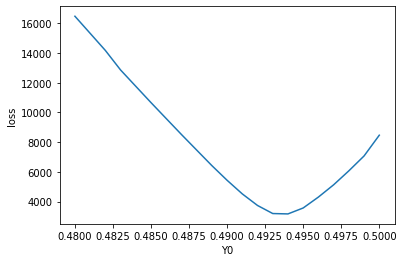

In [11]:
plt.plot(y0_tested ,loss_obtained)
plt.ylabel('loss')
plt.xlabel('Y0')
plt.show()

Best value for Y0 is 0.494

###Gear ratio estimation
Now that we have found a good Y0 value (0.494), let's test different gear ratios to find the best one

In [12]:
loss_obtained = []
GEAR_RATIO_tested = []
for GEAR_RATIO in np.arange(30,50,1):
  prediction = give_prediction(0.494, GEAR_RATIO)
  total_loss = 0
  #in 14000 we are sure not to find any error between scout_odom and speeds
  for t in range(14000):
    roll_x, pitch_y, yaw_z = values_from_quaternion(scout_odom['pose.pose.orientation.x'][t], scout_odom['pose.pose.orientation.y'][t], scout_odom['pose.pose.orientation.z'][t], scout_odom['pose.pose.orientation.w'][t])
    #print('x: ',scout_odom['pose.pose.position.x'][t], ' versus ', prediction[t][0])
    #print('y: ',scout_odom['pose.pose.position.y'][t], ' versus ', prediction[t][1])
    #print('o: ',yaw_z, ' versus ', prediction[t][2])
    total_loss += loss(prediction[t][0],prediction[t][1],prediction[t][2], scout_odom['pose.pose.position.x'][t], scout_odom['pose.pose.position.y'][t], yaw_z)
    #print(prediction[t])
  print('gear ration: ', GEAR_RATIO, ' loss: ', total_loss)
  loss_obtained.append(total_loss)
  GEAR_RATIO_tested.append(GEAR_RATIO)

gear ration:  30  loss:  104021.29443474716
gear ration:  31  loss:  95872.86398947648
gear ration:  32  loss:  90686.36728166416
gear ration:  33  loss:  86215.94612587607
gear ration:  34  loss:  78497.44655719574
gear ration:  35  loss:  68592.23979487461
gear ration:  36  loss:  56515.64595781665
gear ration:  37  loss:  43157.38758635414
gear ration:  38  loss:  28320.990518057843
gear ration:  39  loss:  14207.174897200806
gear ration:  40  loss:  3165.518147631062
gear ration:  41  loss:  16500.201757981256
gear ration:  42  loss:  29437.16847475751
gear ration:  43  loss:  40628.32235337048
gear ration:  44  loss:  49193.65868982357
gear ration:  45  loss:  57693.122956700034
gear ration:  46  loss:  63605.833088785286
gear ration:  47  loss:  68466.2162784735
gear ration:  48  loss:  72472.31620681469
gear ration:  49  loss:  76093.84023067234


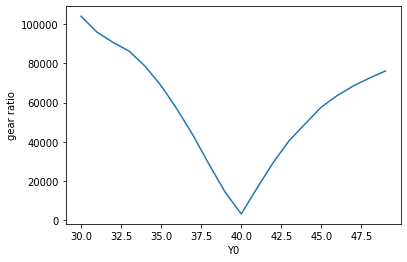

In [13]:
plt.plot(GEAR_RATIO_tested ,loss_obtained)
plt.ylabel('gear ratio')
plt.xlabel('Y0')
plt.show()

It's quite clear that the best gear ratio is 40, since there is a clear minimum at 40

## 3) Estimation from ground pose

We proceed in the same way with the ground pose

Even if gt_pose has a different starting position and orientation, this will not influence the search of the best value of the apparent baseline, since the bias will be applied to all the tests. 


###Y0 estimation

In [14]:
gt_pose

,Unnamed: 0,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,pose.position.x,pose.position.y,pose.position.z,pose.orientation.x,pose.orientation.y,pose.orientation.z,pose.orientation.w
0,0,1.617792e+09,45744,1617791999,222941307,world,-0.832142,0.426362,0.324720,0.022165,-0.010446,-0.533567,0.845403
1,1,1.617792e+09,45745,1617791999,223665997,world,-0.832142,0.426362,0.324720,0.022165,-0.010446,-0.533567,0.845403
2,2,1.617792e+09,45746,1617791999,226267032,world,-0.832142,0.426362,0.324720,0.022165,-0.010446,-0.533567,0.845403
3,3,1.617792e+09,45747,1617791999,230556536,world,-0.832142,0.426362,0.324720,0.022165,-0.010446,-0.533567,0.845403
4,4,1.617792e+09,45748,1617791999,233012675,world,-0.832142,0.426362,0.324720,0.022165,-0.010446,-0.533567,0.845403
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18004,18004,1.617792e+09,63748,1617792281,545081329,world,-0.852457,0.067624,0.322794,0.035322,0.006182,-0.583417,0.811381
18005,18005,1.617792e+09,63749,1617792281,629585802,world,-0.852457,0.067624,0.322794,0.035322,0.006182,-0.583417,0.811381
18006,18006,1.617792e+09,63750,1617792281,630320373,world,-0.852457,0.067624,0.322794,0.035322,0.006182,-0.583417,0.811381
18007,18007,1.617792e+09,63751,1617792281,636034583,world,-0.852457,0.067624,0.322794,0.035322,0.006182,-0.583417,0.811381


In [15]:
loss_obtained = []
y0_tested = []
for y0 in np.arange(0.1,1.1,0.01):
#for y0 in [0.49]:
  prediction = give_prediction(y0,40)
  total_loss = 0
  for t in range(14000):
    roll_x, pitch_y, yaw_z = values_from_quaternion(gt_pose['pose.orientation.x'][t], gt_pose['pose.orientation.y'][t], gt_pose['pose.orientation.z'][t], gt_pose['pose.orientation.w'][t])
    #print('x: ',gt_pose['pose.position.x'][t], ' versus ', prediction[t][0])
    #print('y: ',gt_pose['pose.position.y'][t], ' versus ', prediction[t][1])
    #print('o: ',yaw_z, ' versus ', prediction[t][2])
    total_loss += loss(prediction[t][0],prediction[t][1],prediction[t][2], gt_pose['pose.position.x'][t], gt_pose['pose.position.y'][t], yaw_z)
    #print(prediction[t])
  print('Y0: ', y0, ' loss: ', total_loss)
  loss_obtained.append(total_loss)
  y0_tested.append(y0)

Y0:  0.1  loss:  82566.96229940889
Y0:  0.11  loss:  106009.26950880152
Y0:  0.12  loss:  262780.50109752425
Y0:  0.13  loss:  84489.12029947202
Y0:  0.13999999999999999  loss:  144056.8149768271
Y0:  0.14999999999999997  loss:  95368.65593428559
Y0:  0.15999999999999998  loss:  92459.92385148763
Y0:  0.16999999999999998  loss:  65748.31576378002
Y0:  0.17999999999999997  loss:  102378.42380636364
Y0:  0.18999999999999995  loss:  87148.50257858775
Y0:  0.19999999999999996  loss:  96084.68739749923
Y0:  0.20999999999999996  loss:  185058.3040755212
Y0:  0.21999999999999995  loss:  282084.2407679461
Y0:  0.22999999999999995  loss:  332658.5621694477
Y0:  0.23999999999999994  loss:  323262.8307933797
Y0:  0.24999999999999992  loss:  270392.5851984083
Y0:  0.2599999999999999  loss:  201090.76808383936
Y0:  0.2699999999999999  loss:  140646.76469677972
Y0:  0.2799999999999999  loss:  112624.81481044983
Y0:  0.2899999999999999  loss:  99843.03985313722
Y0:  0.29999999999999993  loss:  92107.

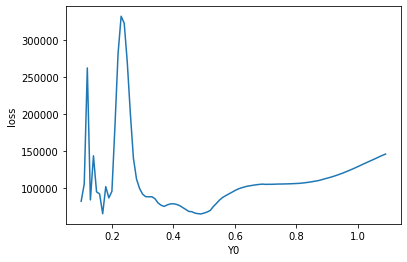

In [16]:
plt.plot(y0_tested, loss_obtained)
plt.ylabel('loss')
plt.xlabel('Y0')
plt.show()

Best value of Y0 is again around 0.49. We do a serch with the precision of 1 millimeter

In [17]:
loss_obtained = []
y0_tested = []
for y0 in np.arange(0.48,0.50,0.001):
#for y0 in [0.49]:
  prediction = give_prediction(y0,40)
  total_loss = 0
  for t in range(14000):
    roll_x, pitch_y, yaw_z = values_from_quaternion(gt_pose['pose.orientation.x'][t], gt_pose['pose.orientation.y'][t], gt_pose['pose.orientation.z'][t], gt_pose['pose.orientation.w'][t])
    #print('x: ',gt_pose['pose.position.x'][t], ' versus ', prediction[t][0])
    #print('y: ',gt_pose['pose.position.y'][t], ' versus ', prediction[t][1])
    #print('o: ',yaw_z, ' versus ', prediction[t][2])
    total_loss += loss(prediction[t][0],prediction[t][1],prediction[t][2], gt_pose['pose.position.x'][t], gt_pose['pose.position.y'][t], yaw_z)
    #print(prediction[t])
  print('Y0: ', y0, ' loss: ', total_loss)
  loss_obtained.append(total_loss)
  y0_tested.append(y0)

Y0:  0.48  loss:  65820.78616156465
Y0:  0.481  loss:  65752.56911292554
Y0:  0.482  loss:  65679.74771605889
Y0:  0.483  loss:  65496.50190025396
Y0:  0.484  loss:  65476.290105681015
Y0:  0.485  loss:  65464.96252790483
Y0:  0.486  loss:  65457.35031151199
Y0:  0.487  loss:  65454.83695213535
Y0:  0.488  loss:  65464.19051715464
Y0:  0.489  loss:  65477.87603014625
Y0:  0.49  loss:  65503.19150584833
Y0:  0.491  loss:  65541.85658482029
Y0:  0.492  loss:  65581.16262542247
Y0:  0.493  loss:  65636.96977347376
Y0:  0.494  loss:  65693.99742432826
Y0:  0.495  loss:  65777.29654760043
Y0:  0.496  loss:  65920.5861380781
Y0:  0.497  loss:  66007.9631103925
Y0:  0.498  loss:  66116.62585454385
Y0:  0.499  loss:  66234.38469985525
Y0:  0.5  loss:  66673.8714056275


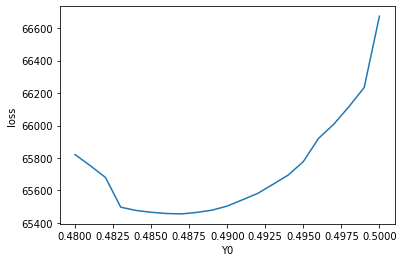

In [18]:
plt.plot(y0_tested, loss_obtained)
plt.ylabel('loss')
plt.xlabel('Y0')
plt.show()

Best value is 0.493, and not 0.494 as in odom. Since the difference between the loss of 0,493 and 0.494 in the gt_pose search is very small, we will use 0.494, since gt_pose is more subjected to noise

### Gear ratio estimation

In [19]:
loss_obtained = []
GEAR_tested = []
for GEAR in np.arange(30,50,1):
#for y0 in [0.49]:
  prediction = give_prediction(0.494,GEAR)
  total_loss = 0
  for t in range(14000):
    roll_x, pitch_y, yaw_z = values_from_quaternion(gt_pose['pose.orientation.x'][t], gt_pose['pose.orientation.y'][t], gt_pose['pose.orientation.z'][t], gt_pose['pose.orientation.w'][t])
    #print('x: ',gt_pose['pose.position.x'][t], ' versus ', prediction[t][0])
    #print('y: ',gt_pose['pose.position.y'][t], ' versus ', prediction[t][1])
    #print('o: ',yaw_z, ' versus ', prediction[t][2])
    total_loss += loss(prediction[t][0],prediction[t][1],prediction[t][2], gt_pose['pose.position.x'][t], gt_pose['pose.position.y'][t], yaw_z)
    #print(prediction[t])
  print('gear: ', GEAR, ' loss: ', total_loss)
  loss_obtained.append(total_loss)
  GEAR_tested.append(GEAR)

gear:  30  loss:  93134.73345840663
gear:  31  loss:  89650.49043457379
gear:  32  loss:  87731.91165384793
gear:  33  loss:  85293.91653688083
gear:  34  loss:  82116.77637002646
gear:  35  loss:  77870.47504487222
gear:  36  loss:  73833.97371652813
gear:  37  loss:  70549.62709342451
gear:  38  loss:  68330.57723249508
gear:  39  loss:  66560.19404182528
gear:  40  loss:  65693.99742432826
gear:  41  loss:  66783.20581792036
gear:  42  loss:  67884.79513636687
gear:  43  loss:  72986.36350442677
gear:  44  loss:  76677.14150940589
gear:  45  loss:  81006.71752919634
gear:  46  loss:  82837.18957259489
gear:  47  loss:  84182.64049150799
gear:  48  loss:  85280.48162039056
gear:  49  loss:  86585.62227024917


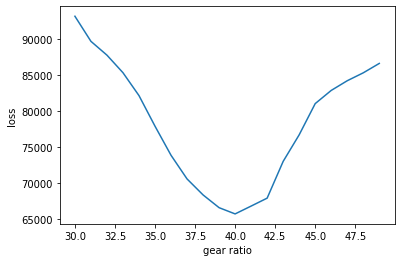

In [20]:
plt.plot(GEAR_tested, loss_obtained)
plt.ylabel('loss')
plt.xlabel('gear ratio')
plt.show()

Again, it's clear that the gear ratio is 40

## Conclusions

Y0 found: 0.494 meters 

(apparent baseline = 2*Y0 : 0.988 meters)

Gear ratio found: 40

This optimization is very rough, since the loss function is a simple sum of the squared errors of three values: position x, position y and orientation. However, even this rough loss function showed clear minimums for both Y0 and gear ratio. The values found generated gave also good results in the ROS simulations. I think that a loss function that normalise the errors between the ones that come from meters (x and y) and the ones that come from radiants (orientation) could be better in expressing the goal, but I was unsure on the criteria to use. 